In [ ]:
!pip install scipy geopandas

In [148]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

### Exercise 1. Geometry

In [149]:
from shapely.wkt import loads
from shapely.geometry import Point, LineString, Polygon

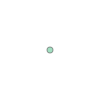

In [152]:
# load a point
point1 = loads('Point (30 20)')
point1

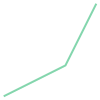

In [153]:
# load a line string
line1 = loads("LINESTRING (10 10, 30 20, 40 40)")
line1

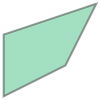

In [156]:
# load a polygon
polygon1 = loads("POLYGON ((40 40, 10 30, 10 10, 30 20, 40 40))")
polygon1

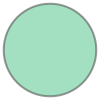

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((40 20, 39.95184726672197 19.0198285967044, 39.80785280403231 18.04909677983872, 39.56940335732209 17.09715322745538, 39.23879532511287 16.17316567634911, 38.81921264348355 15.28603263174003, 38.31469612302546 14.44429766980398, 37.73010453362738 13.65606715836355, 37.07106781186548 12.92893218813453, 36.34393284163646 12.26989546637264, 35.55570233019603 11.68530387697455, 34.71396736825999 11.18078735651645, 33.82683432365091 10.76120467488714, 32.90284677254463 10.43059664267792, 31.9509032201613 10.1921471959677, 30.98017140329562 10.04815273327803, 30.00000000000002 10, 29.01982859670441 10.04815273327803, 28.04909677983873 10.19214719596769, 27.09715322745539 10.43059664267791, 26.17316567634912 10.76120467488713, 25.28603263174004 11.18078735651644, 24.44429766980399 11.68530387697453, 23.65606715836356 12.26989546637262, 22.92893218813454 12.92893218813451, 22.26989546637264 13.65606715836353, 21.68530387697456 14.444297669803

In [158]:
# exercise 1
buffer1 = point1.buffer(10)
display(buffer1)
print(type(buffer1))
print(buffer1.wkt)

### Exercise 2. Coordinate Reference System (CRS)

In [159]:
import pandas as pd
import geopandas as gpd

In [161]:
# read links data
links_df = pd.read_csv('map_data/berkeley_links.csv')
links_df.head()

,link_id,start_node_id,end_node_id,type,length,maxmph,lanes,capacity,fft,start_osmid,end_osmid,geometry
0,0,222,210,secondary,127.923367,25.0,2,3800,11.446276,53096087_m,53091866_m,"LINESTRING (-122.2690042 37.87749114999998, -1..."
1,1,177,222,secondary,135.477223,25.0,2,3800,12.122177,53096090_m,53096087_m,"LINESTRING (-122.269111 37.87842139999998, -12..."
2,2,172,236,secondary,134.053209,25.0,2,3800,11.994759,53055193_m,239616956_m,"LINESTRING (-122.26859415 37.87387224999998, -..."
3,3,229,169,secondary,311.433085,25.0,2,3800,27.866285,56006420_m,239669505_m,LINESTRING (-122.2724628088398 37.890200696914...
4,4,169,229,secondary,311.433085,25.0,2,3800,27.866285,239669505_m,56006420_m,LINESTRING (-122.272362415405 37.8887731671388...


In [162]:
# extract the geometry of the link 161
links_gdf = gpd.GeoDataFrame(links_df, crs='epsg:4326', 
                             geometry=links_df['geometry'].map(loads))

[(-122.2676951, 37.8931481), (-122.2676211, 37.89319560000001), (-122.265886, 37.89430610000001)]
0.0021479774506900375


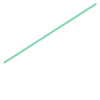

In [166]:
link2_geographic = links_gdf.loc[links_df['link_id']==161].iloc[0].geometry
print( list(link2_geographic.coords) )
print( link2_geographic.length )
display(links_gdf.loc[links_df['link_id']==161].iloc[0].geometry)

In [167]:
link2_mercator = links_gdf.to_crs(3857).loc[links_df['link_id']==161].iloc[0].geometry
print('Length of link 161 in Mercator projection is {} m'.format(link2_mercator.length))
link2_utm = links_gdf.to_crs(26910).loc[links_df['link_id']==161].iloc[0].geometry
print('Length of link 161 in UTM Zone 10N projection is {} m'.format(link2_utm.length))

Length of link 161 in Mercator projection is 259.30760182421903 m
Length of link 161 in UTM Zone 10N projection is 204.4808175266719 m


In [168]:
# we can also calculate it by hand
[(x1, y1), (x2, y2), (x3, y3)] = list(link2_mercator.coords)
link2_mercator_length = np.sqrt((y2-y1)**2 + (x2-x1)**2) + np.sqrt((y3-y2)**2 + (x3-x2)**2)
print('Length of link 161 in Mercator projection is {} m'.format(link2_mercator_length))

[(x1, y1), (x2, y2), (x3, y3)] = list(link2_utm.coords)
link2_utm_length = np.sqrt((y2-y1)**2 + (x2-x1)**2) + np.sqrt((y3-y2)**2 + (x3-x2)**2)
print('Length of link 161 in UTM Zone 10N projection is {} m'.format(link2_utm_length))

Length of link 161 in Mercator projection is 259.30760182421903 m
Length of link 161 in UTM Zone 10N projection is 204.4808175266719 m


### Exercise 3. Spatial index

In [169]:
import time
import shapely.ops
from scipy.spatial import Voronoi, voronoi_plot_2d

In [170]:
# read the parcel data
berkeley_parcels = gpd.read_file('map_data/berkeley_parcels/parcels.shp')

# read the node data
berkeley_nodes = pd.read_csv('../../Fall2020/traffic_data/berkeley_nodes.csv')
berkeley_nodes = gpd.GeoDataFrame(berkeley_nodes, crs='epsg:4326', geometry=[Point(xy) for xy in zip(berkeley_nodes.lon, berkeley_nodes.lat)])

# read the evacuation zone
evacuation_zone = gpd.read_file('map_data/evacuation_zone/evacuation_zone.shp')

(4194000.0, 4195000.0)

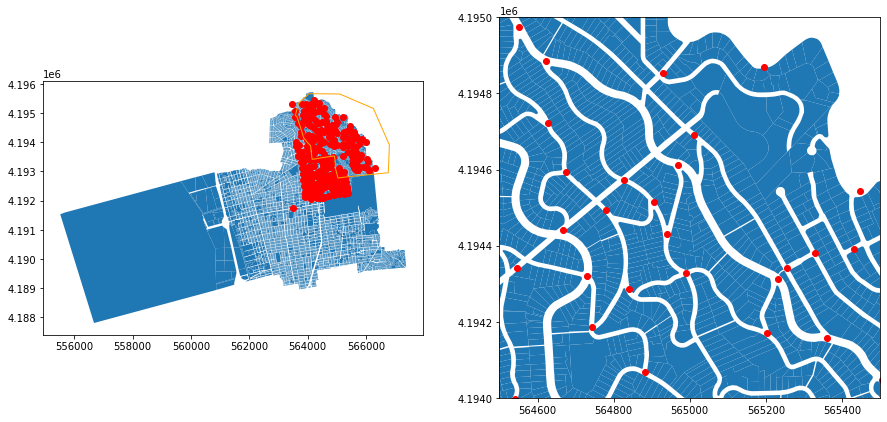

In [173]:
# plot figure
fig, ax = plt.subplots(1, 2, figsize=(15,15))
berkeley_parcels.to_crs(26910).plot(ax = ax[0])
berkeley_nodes.to_crs(26910).plot(ax = ax[0], color='red')
evacuation_zone.to_crs(26910).plot(ax = ax[0], facecolor='none', edgecolor='orange')
berkeley_parcels.to_crs(26910).plot(ax = ax[1])
berkeley_nodes.to_crs(26910).plot(ax = ax[1], color='red')
ax[1].set_xlim([564500, 565500])
ax[1].set_ylim([4194000, 4195000])

In [174]:
# add Voronoi diagram
# based on: https://gis.stackexchange.com/questions/337561/making-polygon-for-every-point-in-set-using-voronois
x = berkeley_nodes.geometry.x.values
y = berkeley_nodes.geometry.y.values
coords = np.vstack((x, y)).T
vor = Voronoi(coords)

lines = [shapely.geometry.LineString(vor.vertices[line]) for line in 
    vor.ridge_vertices if -1 not in line]
polys = shapely.ops.polygonize(lines)
voronois = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys), crs='epsg:4326').to_crs(26910)

voronois = gpd.overlay(voronois, evacuation_zone.to_crs(26910))
voronois['id'] = np.arange(voronois.shape[0])
voronois.head()

,id,geometry
0,0,"POLYGON ((565182.478 4192861.916, 565147.566 4..."
1,1,"POLYGON ((565147.566 4192854.883, 565182.478 4..."
2,2,"POLYGON ((565182.478 4192861.916, 565211.205 4..."
3,3,"POLYGON ((565211.205 4193125.501, 565086.385 4..."
4,4,"POLYGON ((565086.385 4193036.960, 565096.025 4..."


(4194000.0, 4195000.0)

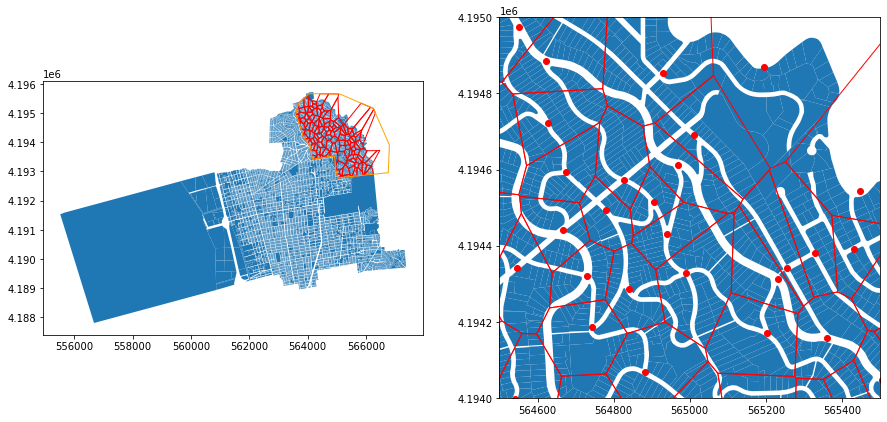

In [176]:
# plot voronois
fig, ax = plt.subplots(1, 2, figsize=(15,15))

# whole plot
berkeley_parcels.to_crs(26910).plot(ax = ax[0])
voronois.to_crs(26910).plot(ax = ax[0], facecolor='none', edgecolor='red')
evacuation_zone.to_crs(26910).plot(ax = ax[0], facecolor='none', edgecolor='orange')

# zoom in
berkeley_parcels.to_crs(26910).plot(ax = ax[1])
berkeley_nodes.to_crs(26910).plot(ax = ax[1], color='red')
voronois.to_crs(26910).plot(ax = ax[1], facecolor='none', edgecolor='red')
ax[1].set_xlim([564500, 565500])
ax[1].set_ylim([4194000, 4195000])

In [177]:
# extract the parcel centroid
berkeley_parcels['centroid'] = berkeley_parcels.apply(lambda x: x['geometry'].centroid, axis=1)
berkeley_parcels_centroid = berkeley_parcels.set_geometry('centroid').to_crs(26910)

In [179]:
# method 1: without spatial indexing
t0 = time.time()
parcels_per_node_1 = dict()

for voronoi_zone in voronois.itertuples():
    voronoi_gemetry = getattr(voronoi_zone, 'geometry')
    parcels_evacuate = berkeley_parcels_centroid[
        berkeley_parcels_centroid.intersects(voronoi_gemetry)]
    parcels_per_node_1[getattr(voronoi_zone, 'id')] = parcels_evacuate.shape[0]

print('It takes {:.2f} seconds to compute without spatial index'.format(time.time()-t0))

It takes 14.27 seconds to compute without spatial index


In [180]:
# method 2: with spatial indexing
t1 = time.time()
parcels_sindex = berkeley_parcels_centroid.sindex
parcels_per_node_2 = dict()

for voronoi_zone in voronois.itertuples():
    voronoi_gemetry = getattr(voronoi_zone, 'geometry')
    coarse_parcel_ids = list(parcels_sindex.intersection(voronoi_gemetry.bounds))
    coarse_parcels = berkeley_parcels_centroid.iloc[coarse_parcel_ids]
    parcels_evacuate = coarse_parcels[coarse_parcels.intersects(voronoi_gemetry)]
    parcels_per_node_2[getattr(voronoi_zone, 'id')] = parcels_evacuate.shape[0]

print('It takes {:.2f} seconds to compute with spatial index'.format(time.time()-t1))

equal_items = {k: parcels_per_node_1[k] for k in parcels_per_node_1 if k in parcels_per_node_2 and parcels_per_node_1[k] == parcels_per_node_2[k]}
print('There are {} voronoi shapes in method 1, {} in method 2, {} elements are equal'.format(len(parcels_per_node_1), len(parcels_per_node_2), len(equal_items)))

It takes 2.56 seconds to compute with spatial index
There are 138 voronoi shapes in method 1, 138 in method 2, 138 elements are equal


### backup materials

In [ ]:
fire = gpd.GeoDataFrame(pd.DataFrame({'id': [0], 'name': ['ignition']}), crs='epsg:4326', geometry=[Point((-122.2502, 37.9021))])

fire_propagation = pd.DataFrame([[distance, fire.to_crs(26910).iloc[0].geometry.buffer(distance*1609)] for distance in np.arange(0.2, 5, 0.2)], columns=['distance', 'geometry'])

fire_propagation = gpd.GeoDataFrame(fire_propagation, crs='epsg:26910', geometry=fire_propagation['geometry'])

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
berkeley_parcels.to_crs(26910).plot(ax = ax)
fire_propagation.plot(ax = ax, facecolor='none', edgecolor='orange')

In [ ]:
# extract the parcel centroid
berkeley_parcels['centroid'] = berkeley_parcels.apply(lambda x: x['geometry'].centroid, axis=1)
berkeley_parcels_centroid = berkeley_parcels.set_geometry('centroid').to_crs(26910)

In [ ]:
# method 1: without spatial indexing
t0 = time.time()

for buffer_zone in fire_propagation.itertuples():
    parcels_evacuate = berkeley_parcels_centroid[
        berkeley_parcels_centroid.intersects(
            getattr(buffer_zone, 'geometry'))]
    print('{} parcels.'.format(parcels_evacuate.shape[0]))

print('It takes {:.2f} seconds to compute'.format(time.time()-t0))

In [ ]:
# method 2: with spatial indexing
t1 = time.time()
parcels_sindex = berkeley_parcels_centroid.sindex

for buffer_zone in fire_propagation.itertuples():
    buffer_gemetry = getattr(buffer_zone, 'geometry')
    coarse_parcel_ids = list(parcels_sindex.intersection(buffer_gemetry.bounds))
    coarse_parcels = berkeley_parcels_centroid.iloc[coarse_parcel_ids]
    parcels_evacuate = coarse_parcels[coarse_parcels.intersects(buffer_gemetry)]
    print('{} parcels.'.format(parcels_evacuate.shape[0]))

print('It takes {:.2f} seconds to compute'.format(time.time()-t1))